In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from heat_plot_config import *

In [3]:
from plot_config import *

In [4]:
rerun = True

In [5]:
if rerun:
    for time_slice in [slice(None,None,-1)]:
        particle_path = '/sciserver/filedb04-01/ocean/wenrui_temp/particle_file/WA/'
        pre = 'precalc/wau_backward_'
        # particle_path = '/sciserver/filedb11-01/ocean/wenrui_temp/particle_file/holliday/'
        table_path = particle_path+'table1y.zarr'
        map_path = particle_path+'map1y.zarr'
        maps = xr.open_zarr(map_path)
        table= xr.open_zarr(table_path)
        
        cum = table.isel(time = time_slice).cumsum(dim = 'time')
        
        size = len(cum.time)
        
        mean = cum.mean(dim = 'space')
        std = cum.std(dim = 'space')
        
        for var in mean.data_vars:
            print(var,end = ' ')
            mean[var] = mean[var].chunk(size)
            if var in ['sl','sf']:
                mean[var] = table[var].isel(time = time_slice).mean(dim = 'space').chunk(size)
        for var in std.data_vars:
            print(var,end = ' ')
            std[var] = std[var].chunk(size)
            if var in ['sl','sf']:
                std[var] = table[var].isel(time = time_slice).std(dim = 'space').chunk(size)
        
        mean.to_zarr(pre+'mean.zarr',mode = 'w')
        std.to_zarr(pre+'std.zarr',mode = 'w')

A E F I dep dif_h dif_v e_ua lat lhs lon sf sl A E F I dep dif_h dif_v e_ua lat lhs lon sf sl 

# Let the plotting begin

In [6]:
just_for_time = '/sciserver/filedb10-01/ocean/wenrui_temp/vol_budget'

rtime = np.array(xr.open_zarr(just_for_time).time)

In [7]:
# extra_text = 'The spread are enhanced 10 times'

In [8]:
meta = [
    # ('nep_backward','five','lineplot_nep_backward.png'),
    ('wau_backward','five','figure3(d)'),
]

In [9]:
rhs_list = [i for i in rhs_list if i !='F']

In [10]:
mean['I'] = mean['F']+mean['I']

In [11]:
idate = 6999

A
dif_v
dif_h
E
e_ua
I


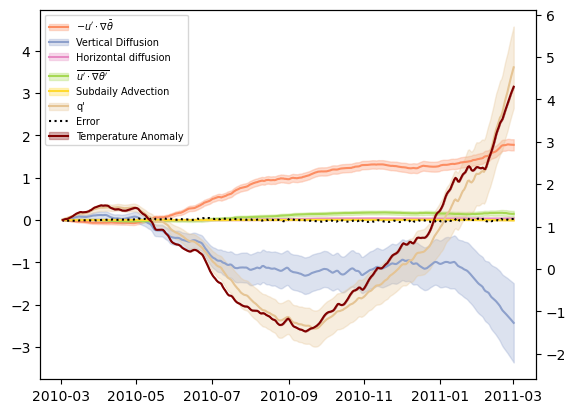

In [12]:
# case = 'salty'
# duration = 'five'
# save_as = 'figure4(b).png'
for case, duration, save_as in meta:

    plt.clf()
    pre = 'precalc/'+case+'_'
    
    # if 'nep' in case:
    #     TOTAL_VOLUME,NUMBER_OF_PARTICLE,VOLUME_EACH,idate = TOTAL_VOLUME_nep,NUMBER_OF_PARTICLE_nep,VOLUME_EACH_nep,nep_idate
    # if 'wau' in case:
        # TOTAL_VOLUME,NUMBER_OF_PARTICLE,VOLUME_EACH,idate = TOTAL_VOLUME_wau,NUMBER_OF_PARTICLE_wau,VOLUME_EACH_nep,wau_idate
    NUMBER_OF_PARTICLE = 10009
    mean = xr.open_zarr(pre+'mean.zarr')
    std = xr.open_zarr(pre+'std.zarr')
    xtime = rtime[idate:idate-len(mean.time):-1]
    
    ax = plt.axes()
    handles = []
    labels = []
    for var in rhs_list:
        print(var)
        a_mean = -mean[var][::-1]
        a_std = 10*std[var][::-1]/np.sqrt(NUMBER_OF_PARTICLE-1)
        mean_line, = ax.plot(xtime, a_mean, label=case_term_dic[var], color=color_dic[var])
        spread_area = ax.fill_between(xtime, a_mean - a_std, a_mean + a_std, alpha=0.3, label=case_term_dic[var], color=color_dic[var])
        handles.append((mean_line, spread_area))
        labels.append(case_term_dic[var])
    mean['tot'] = (mean['A']+mean['e_ua']+mean['E']+mean['dif_h']+mean['dif_v']+mean['I'])
    offset = float(mean['sf'][0])
    salt = np.array(mean['sl'].data)
    to_explain = salt - offset
    error = to_explain + mean['tot']
    error_line, = ax.plot(xtime, error[::-1],':', color='k')
    handles.append(error_line)
    labels.append('Error')
    ax2 = ax.twinx()
    ax2.set_ylim(ax.get_ylim()[0] + offset, ax.get_ylim()[1] + offset)
    if case == 'nep_backward':
        sal_color = nep_theme_color
    elif case == 'wau_backward':
        sal_color = wau_theme_color
    salt_line, = ax.plot(xtime, salt[::-1]-offset,color = sal_color)
    a_std = np.array(std['sl'])/np.sqrt(NUMBER_OF_PARTICLE-1)
    spread_area = ax.fill_between(xtime, salt[::-1] - a_std[::-1]-offset, salt[::-1] + a_std[::-1]-offset, alpha=0.3, color = sal_color)
    handles.append((salt_line,spread_area))
    labels.append('Temperature Anomaly')
    # invisible_line, = plt.plot([],[],c = 'none')
    legend = ax.legend(handles,labels,fontsize = 7,loc = 0)
    plt.setp(legend.get_title(),fontsize=7)

    ylim = plt.gca().get_ylim()
    plt.ylim(*ylim)
    if save_as:
        plt.savefig(save_as+format,dpi = dpi)